# 🎚️ Mixed precision training

The following example uses `deepmind` `jmp` library to train for mixed precision.

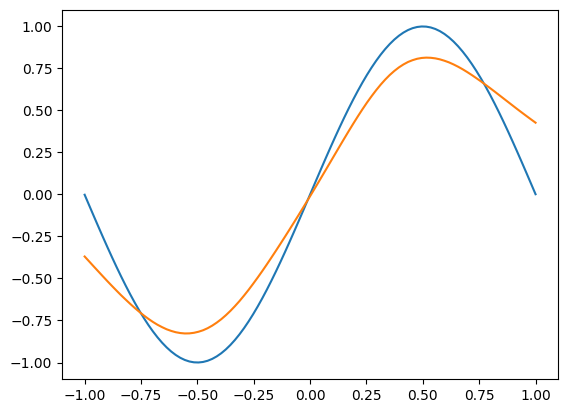

In [1]:
import serket as sk
import jax
import jax.numpy as jnp
import jmp  # https://github.com/deepmind/jmp mixed precision library
import matplotlib.pyplot as plt

half = jnp.float16  # On TPU this should be jnp.bfloat16.
full = jnp.float32

mp_policy = jmp.Policy(compute_dtype=half, param_dtype=full, output_dtype=half)

net = sk.nn.Sequential(
    sk.nn.Linear(
        in_features=1,
        out_features=50,
        dtype=mp_policy.param_dtype,  # +
    ),
    jax.numpy.tanh,
    sk.nn.Linear(
        in_features=50,
        out_features=1,
        dtype=mp_policy.param_dtype,  # +
    ),
    mp_policy.cast_to_output,  # +
)

net = sk.tree_mask(net)
x = jnp.linspace(-1, 1, 100)[..., None]
y = jnp.sin(x * 3.14)


@jax.jit
def train_step(net, x, y):
    def loss_func(net, x, y):
        net = sk.tree_unmask(net)
        net, x = mp_policy.cast_to_compute((net, x))  # +
        ypred = jax.vmap(net)(x)
        loss = jnp.mean((ypred - y) ** 2)
        return loss

    grad = jax.grad(loss_func)(net, x, y)
    net = jax.tree_map(lambda p, g: p - 1e-3 * g, net, grad)
    return net


for i in range(10_000):
    net = train_step(net, x, y)

net = sk.tree_unmask(net)

plt.plot(x, y, label="true")
plt.plot(x, jax.vmap(net)(x), label="pred")